In [15]:
import os
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

In [16]:
# run params
SECTION = 'vae'
RUN_ID = '0002'
DATA_NAME = 'digits'
RUN_FOLDER = 'run/{}/'.format(SECTION)
RUN_FOLDER += '_'.join([RUN_ID, DATA_NAME])

In [17]:
NUM_CLASSES = 10

transform = transforms.Compose(
    [transforms.ToTensor()])

testset = torchvision.datasets.MNIST(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=10000,
                                         shuffle=False)

In [18]:
class Encoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(64*6*6, 2)


        self.encoder = nn.Sequential(
            nn.Conv2d(1, 32, 3, 1),
            nn.Conv2d(32, 64, 3, 2),
            nn.Conv2d(64, 64, 3, 2),
            nn.Conv2d(64, 64, 3, 1),
        )
    def forward(self, x):
        for layer in self.encoder:
            x = F.pad(layer(x), (1,0,1,0))
            x = F.leaky_relu(x)
            
        x = self.linear1(self.flatten(x))
        return x


In [19]:
class Decoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.linear1 = nn.Linear(2, 64*6*6)


        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 64, 3, 1, 1),
            nn.ConvTranspose2d(64, 64, 3, 2, 1),
            nn.ConvTranspose2d(64, 32, 3, 2, 1),
            nn.ConvTranspose2d(32, 1, 3, 1, 1),
        )
    def forward(self, x):
        x = self.linear1(x)
        x = x.reshape(-1, 64, 6, 6)
        for i, layer in enumerate(self.decoder):
            if i == len(self.decoder) - 1:
                x = layer(x)
            else:
                x = F.pad(layer(x), (0,1,0,1))
                x = F.leaky_relu(x)
        return F.sigmoid(x)


In [20]:
class AutoEncoder(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    def forward(self, x):
        t = self.encoder(x)
        x = self.decoder(t)
        return x, t

In [23]:
model =AutoEncoder()
model = torch.load(RUN_FOLDER + '/weights/weight.pt').cpu()

c:\Users\ggh5454\.conda\envs\pytorch_env1\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


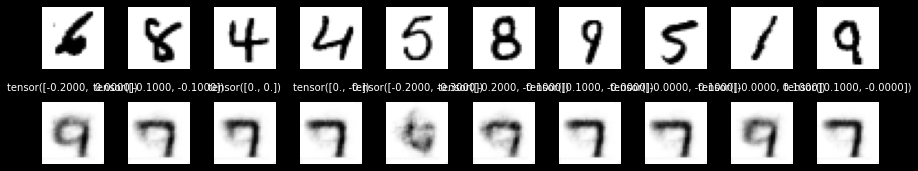

In [24]:
n_to_show = 10
images, labels = next(iter(testloader))

example_idx = np.random.choice(range(len(images)), n_to_show)
example_images = images[example_idx]


with torch.no_grad():
    reconst_images, z_points = model(example_images)

fig = plt.figure(figsize=(15, 3))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(n_to_show):
    img = example_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+1)
    sub.axis('off')
    sub.text(0.5, -0.35, str(np.round(z_points[i],1)), fontsize=10, ha='center', transform=sub.transAxes)
            
    sub.imshow(img, cmap='gray_r')

for i in range(n_to_show):
    img = reconst_images[i].squeeze()
    sub = fig.add_subplot(2, n_to_show, i+n_to_show+1)
    sub.axis('off')
    sub.imshow(img, cmap='gray_r')


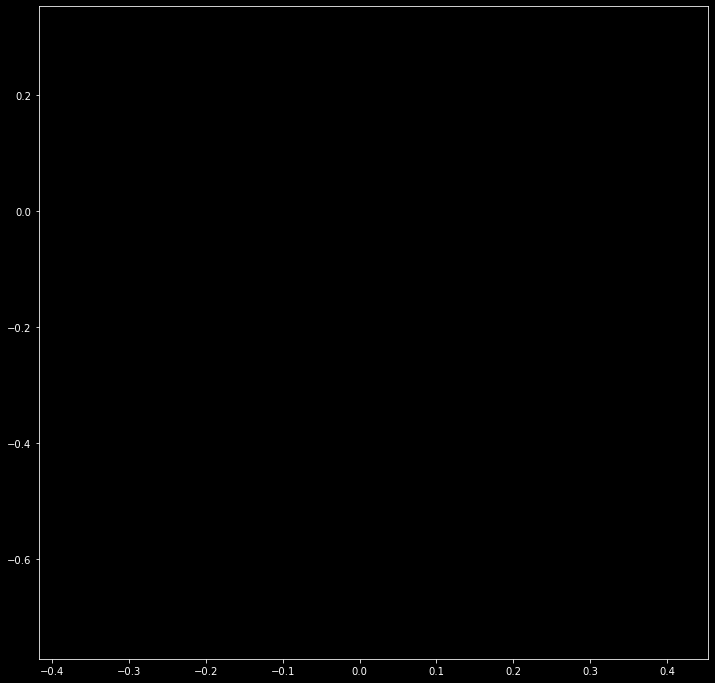

In [25]:
n_to_show = 5000
grid_size = 15
figsize = 12
images, labels = next(iter(testloader))

example_idx = np.random.choice(range(len(images)), n_to_show)
example_images = images[example_idx]
example_labels = labels[example_idx]

with torch.no_grad():
    _, z_points = model(example_images)

min_x = min(z_points[:, 0])
max_x = max(z_points[:, 0])
min_y = min(z_points[:, 1])
max_y = max(z_points[:, 1])

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)
plt.show()

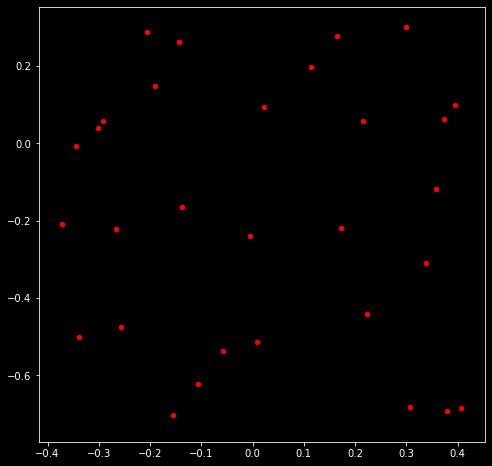

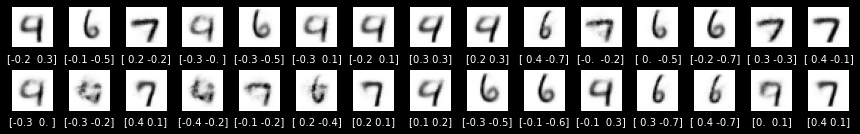

In [26]:
figsize = 8

plt.figure(figsize=(figsize, figsize))
plt.scatter(z_points[:, 0] , z_points[:, 1], c='black', alpha=0.5, s=2)

grid_size = 15
grid_depth = 2
figsize = 15

x = np.random.uniform(min_x,max_x, size = grid_size * grid_depth)
y = np.random.uniform(min_y,max_y, size = grid_size * grid_depth)
z_grid = np.array(list(zip(x, y)), dtype=np.float32)

with torch.no_grad():
    z_grid = torch.from_numpy(z_grid)
    reconst = model.decoder(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'red', alpha=1, s=20)
plt.show()

fig = plt.figure(figsize=(figsize, grid_depth))
fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i in range(grid_size*grid_depth):
    ax = fig.add_subplot(grid_depth, grid_size, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, str(np.round(z_grid[i].numpy(),1)), fontsize=10, ha='center', transform=ax.transAxes)
    
    ax.imshow(reconst[i][0], cmap = 'Greys')

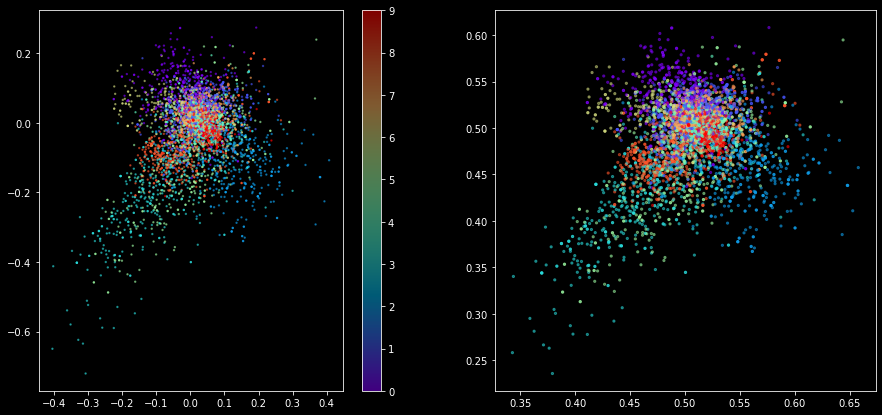

In [27]:
from scipy.stats import norm

n_to_show = 5000
grid_size = 15
fig_height = 7
fig_width = 15

images, labels = next(iter(testloader))

example_idx = np.random.choice(range(len(images)), n_to_show)
example_images = images[example_idx]
example_labels = labels[example_idx]

with torch.no_grad():
    z_points = model.encoder(example_images)
    p_points = norm.cdf(z_points)

fig = plt.figure(figsize=(fig_width, fig_height))

ax = fig.add_subplot(1, 2, 1)
plot_1 = ax.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar(plot_1)

ax = fig.add_subplot(1, 2, 2)
plot_2 = ax.scatter(p_points[:, 0] , p_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=5)



plt.show()

c:\Users\ggh5454\.conda\envs\pytorch_env1\lib\site-packages\torch\nn\functional.py:1960: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


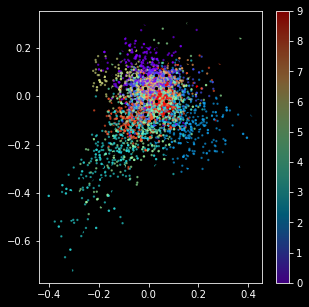

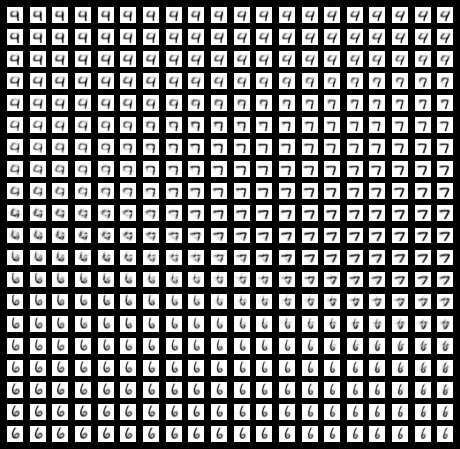

In [28]:
n_to_show = 5000
grid_size = 20
figsize = 8

images, labels = next(iter(testloader))
example_idx = np.random.choice(range(len(images)), n_to_show)
example_images = images[example_idx]
example_labels = labels[example_idx]

with torch.no_grad():
    z_points = model.encoder(example_images)

plt.figure(figsize=(5, 5))
plt.scatter(z_points[:, 0] , z_points[:, 1] , cmap='rainbow' , c= example_labels
            , alpha=0.5, s=2)
plt.colorbar()

# x = norm.ppf(np.linspace(0.05, 0.95, 10))
# y = norm.ppf(np.linspace(0.05, 0.95, 10))
x = np.linspace(min(z_points[:, 0]), max(z_points[:, 0]), grid_size)
y = np.linspace(max(z_points[:, 1]), min(z_points[:, 1]), grid_size)
xv, yv = np.meshgrid(x, y)
xv = xv.flatten()
yv = yv.flatten()
z_grid = np.array(list(zip(xv, yv)),dtype=np.float32)


with torch.no_grad():
    z_grid = torch.from_numpy(z_grid)
    reconst = model.decoder(z_grid)

plt.scatter(z_grid[:, 0] , z_grid[:, 1], c = 'black'#, cmap='rainbow' , c= example_labels
            , alpha=1, s=5)

plt.show()


fig = plt.figure(figsize=(figsize, figsize))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(grid_size**2):
    ax = fig.add_subplot(grid_size, grid_size, i+1)
    ax.axis('off')
    ax.imshow(reconst[i][0], cmap = 'Greys')